In [1]:
# Importing the libraries 
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import pandas as pd

# Checking the availability of CUDA on machine
print("Torch", torch.__version__, "CUDA", torch.version.cuda)
print("Device:", torch.device("cuda:0"))
print(torch.cuda.is_available())



Torch 1.0.0 CUDA 9.0
Device: cuda:0
True


In [2]:
# Loading the data taking 200 at a time
BATCH = 200
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_set = torchvision.datasets.MNIST(
    "mnist_data", transform=transform, train=True, download=True
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH)

test_set = torchvision.datasets.MNIST(
    "mnist_data", transform=transform, train=False, download=True,
)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH)



In [3]:
# I learning Pytorch using the following playlist on youtube
# A part of this code in this cell is take from those learning
# https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(28 * 28, 1024)
        self.hidden_layer1 = nn.Linear(1024, 1024)
        self.hidden_layer2 = nn.Linear(1024, 1024)
        self.hidden_layer3 = nn.Linear(1024, 1024)
        self.hidden_layer4 = nn.Linear(1024, 1024)
        self.hidden_layer5 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 10)
        self.activation = nn.ReLU()

    def forward(self, data):
        data = data.view(-1, 28 * 28).cuda()
        self.data = data
        self.output_input_layer = self.activation(self.input_layer(data))
        self.output_1st_hidden = self.activation(
            self.hidden_layer1(self.output_input_layer)
        )
        self.output_2nd_hidden = self.activation(
            self.hidden_layer2(self.output_1st_hidden)
        )
        self.output_3rd_hidden = self.activation(
            self.hidden_layer3(self.output_2nd_hidden)
        )
        self.output_4th_hidden = self.activation(
            self.hidden_layer4(self.output_3rd_hidden)
        )
        self.output_5th_hidden = self.activation(
            self.hidden_layer5(self.output_4th_hidden)
        )
        self.final_output = self.output_layer(self.output_5th_hidden)
        self.softmax_output = torch.nn.functional.log_softmax(self.final_output, dim=1)
        return self.softmax_output



In [4]:
#Training the network
neural_network = NeuralNet().cuda()
loss_function = nn.CrossEntropyLoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(para, lr=0.001)
loss_list = []
epochs = 35
for t in range(epochs):
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        outputs = neural_network(images.cuda())
        loss = loss_function(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
# For debugging purpose
#     loss_list.append(loss.data.cpu().numpy())
# For debugging purpose
# print(loss.data)
# plt.plot(range(epochs), loss_list)
# plt.show()  



In [5]:
# Testing the trained model
correct = 0
total = 0
save_one = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = neural_network(images)
        _, predicted = torch.max(outputs.data.cuda(), 1)
        _ = _.cuda()
        predicted = predicted.cuda()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct)
print("Accuracy:" , (100.0 * correct / total))



9827
Accuracy: 98.27


For question 1.3 and 1.4 I plotted digits for two different ways. I did so to understand the network better. The first way is explained below, this is same as mentioned in assignment. 

For each image we have 10 Neurons deciding the class of the image. The maximum value out of those 10 predictions decides the label of the class. So for softmax layer, I took max of 10-d vector and for that column got top 10 predictions that predicted the given class label. Similarly I did for the last hidden layer with the only different of taking 10 dimensions randomly out of 1024.


In [6]:
def print_digits_taking_non_max(layer_output, images, labels, random_dimensions_list, random_dimensions=True):
    plt.figure()
    predictions = dict()
    
#     using the same function for softmax and other layers, 
    if random_dimensions:
        dimensions = layer_output[:,random_dimensions_list]
    else:
        dimensions = layer_output
# Trying to arrange the predictions in key-value pair, where key is the index of image and value is the prediciton
    for i in range(1000):      
        predicted_dimension = np.argmax(dimensions[i])
        predictions[i] = predicted_dimension
# For each dimension getting the top 10 images that predicted the given class label. Then plotting them as one row. 
# For few dimensions we will not have 10 images so those blocks will be empty.
    for i in range(10):
        images_index = [k for (k,v) in predictions.items() if v == i]
        images_index = images_index[:10]
        for plot_index, index in enumerate(images_index):
            digit_plot = plt.subplot2grid((10,10), (i,plot_index))
            images = images.cpu()
            digit_plot.imshow(images[index].squeeze(), cmap="gray")
            plt.axis('off')



Here I will pass 1000 samples through Network and output of each layer will be stored. 
These outputs will be used for Printing Digits, PCA and tSNE.

In [7]:
# Part 3
# Taking 1000 samples from the test_set
thousand_test_set = torch.utils.data.Subset(test_set, range(1000))
thousand_test_loader = torch.utils.data.DataLoader(thousand_test_set, batch_size=1000)

# feed forward on thousand samples
with torch.no_grad():
    for data in thousand_test_loader:
        images, labels = data
        #    print(images.shape, labels)
        images = images.cuda()
        labels = labels.cuda()

        outputs = neural_network(images)
        outputs = outputs.cpu()


Below I will plot all the digits for each layer. And then explain my observations

**Digits For the Softmax Layer**

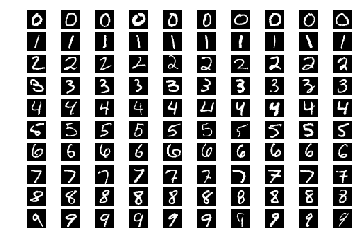

In [8]:
# the outputs is the output from the 1000 examples in above cell
print_digits_taking_non_max(outputs.cpu(),images , labels, [], False)

In [9]:
# Taking 10 random dimensions from 1024 so that we can print digits for other layers 
random_dim = np.random.choice(1024, 10)

**Digit for the fifth hidden layer**

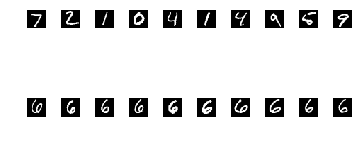

In [10]:
print_digits_taking_non_max(neural_network.output_5th_hidden.cpu(),images , labels, random_dim, True)

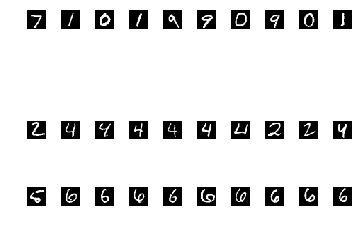

In [11]:
print_digits_taking_non_max(neural_network.output_4th_hidden.cpu(),images , labels, random_dim, True)

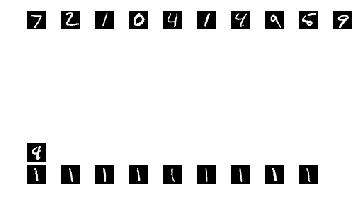

In [12]:
print_digits_taking_non_max(neural_network.output_3rd_hidden.cpu(),images , labels, random_dim, True)

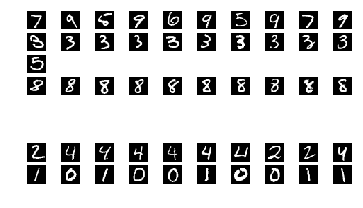

In [13]:
print_digits_taking_non_max(neural_network.output_2nd_hidden.cpu(),images , labels, random_dim, True)

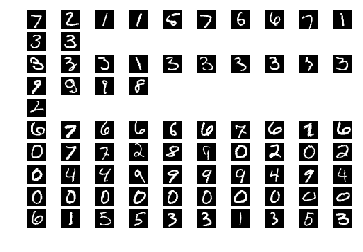

In [14]:
print_digits_taking_non_max(neural_network.output_1st_hidden.cpu(),images , labels, random_dim, True)

**Explaination on the Digits printed from each layer above**
1. We see that the beginning layers have less blank places in the 10 by 10 grid. This is due to the face that we are able to get atlease 10 predictions for given label.
2. As we move ahead in the layer the particular dimension becomes more and more confident about certain features of the image. So we may not have at lease 10 predictions for the given layer. The predictions maybe concentrated to few numbers.
3. Due to this we may find few blank places in certain dimensions

**Second Way of plotting Digits**
Below is the second way I plotted the digits to see how are the results, For each dimenison I took the top 10 values and checked what they are predicting. These are then displayed as one row in the 10 x 10 digits.
Explaination about these is after printing digits from all the layers

In [32]:
def print_digits_using_top_10(layer_output, images, is_random_dimension = True, random_dimensions =[]):
    plt.figure()
    for i in range(10):
        for j in range(10):
            if is_random_dimension:
                #argpartition, learned from stackoverflow
                images_indices = np.argpartition(layer_output[:,random_dimensions[i]],-10)[-10:]
            else:
                images_indices = np.argpartition(layer_output[:,i],-10)[-10:]
            image_index = images_indices[j]
            digit_plot = plt.subplot2grid((10,10), (i,j))
            images = images.cpu()
            digit_plot.imshow(images[image_index].squeeze(), cmap="gray")
            plt.axis('off')



**Second way printing From the softmax output**

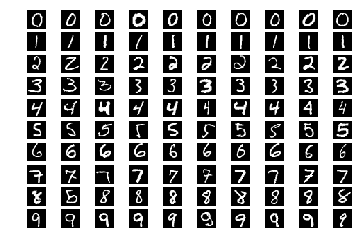

In [33]:
print_digits_using_top_10(neural_network.softmax_output.cpu(), images, [], True)

**Second way printing From the 5th Hidden Layer**

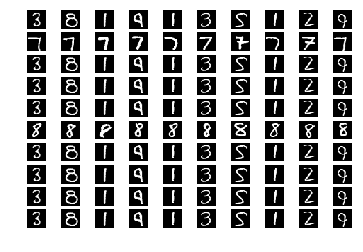

In [17]:
print_digits_using_top_10(neural_network.output_5th_hidden.cpu(), images, [], True)

**Second way printing From the 4th Hidden Layer**

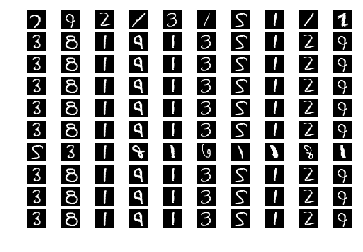

In [18]:
print_digits_using_top_10(neural_network.output_4th_hidden.cpu(), images, [], True)

**Second way printing From the 3rd Hidden Layer**

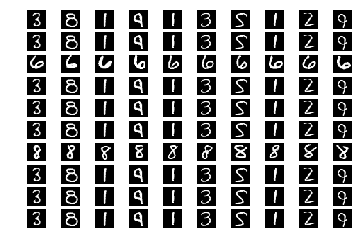

In [19]:
print_digits_using_top_10(neural_network.output_3rd_hidden.cpu(), images, [], True)

**Second way printing From the 2nd Hidden Layer**

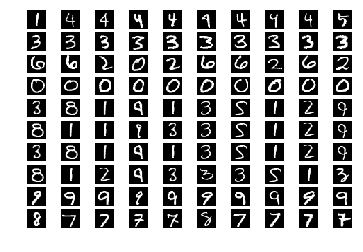

In [20]:
print_digits_using_top_10(neural_network.output_2nd_hidden.cpu(), images, [], True)

**Second way printing From the 1st Hidden Layer**

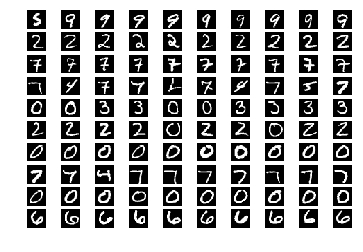

In [21]:
print_digits_using_top_10(neural_network.output_1st_hidden.cpu(), images, [], True)

**Explaination regarding the second way of printing digits**
1. As these are top 10 values from each dimension we see that top 10 values from the each dimenison predict the same digit. This can be observed in the output from the softmax layer.


In [22]:
#Function to plot the PCA and tSNE
def draw_pca_plot(x, y):
    plt.figure(figsize=(15,10))
    pca = PCA(2)
    principal_components = pca.fit_transform(x)
    dataframe = pd.DataFrame(data = y, columns = ['digit'])
    principalDf = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, dataframe], axis = 1)
    digits = [0, 1, 3, 4, 5, 6 ,7, 8, 9 ]
    colors = ['red', 'green', 'blue', 'purple', 'yellow','black','orange','brown','grey','navy']
    mean = finalDf.groupby('digit').mean()
    for digit, color in zip(digits,colors):
            indicesToKeep = finalDf['digit'] == digit
            plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                       , finalDf.loc[indicesToKeep, 'principal component 2']
                       , c = color)
            plt.text(mean.loc[digit,'principal component 1'], mean.loc[digit,'principal component 2'], digit, fontsize=14)
    plt.title("PCA")
    plt.legend(digits)
    plt.grid()

def draw_tsne_plot(x, y):
    plt.figure(figsize=(15,10))
    tsne = TSNE(2)
    tsne = tsne.fit_transform(x)
    dataframe = pd.DataFrame(data = y, columns = ['digit'])
    principalDf = pd.DataFrame(data = tsne, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, dataframe], axis = 1)
    digits = [0, 1, 3, 4, 5, 6 ,7, 8, 9 ]
    colors = ['red', 'green', 'blue', 'purple', 'yellow','black','orange','brown','grey','navy']
    mean = finalDf.groupby('digit').mean()
    for digit, color in zip(digits,colors):
            indicesToKeep = finalDf['digit'] == digit
            plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                       , finalDf.loc[indicesToKeep, 'principal component 2']
                       , c = color)
            plt.text(mean.loc[digit,'principal component 1'], mean.loc[digit,'principal component 2'], digit, fontsize=14)
    plt.title("tSNE")
    plt.legend(digits)
    plt.grid()



In [23]:
# question 5, 6 and 7
# I learned how to do PCA from the below URL, the tSNE was quite similar to this
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

labels = labels.cpu().numpy()

**PCA and tSNE for 784-dim pixels, explaination regarding these is after printing all the scatter plots**

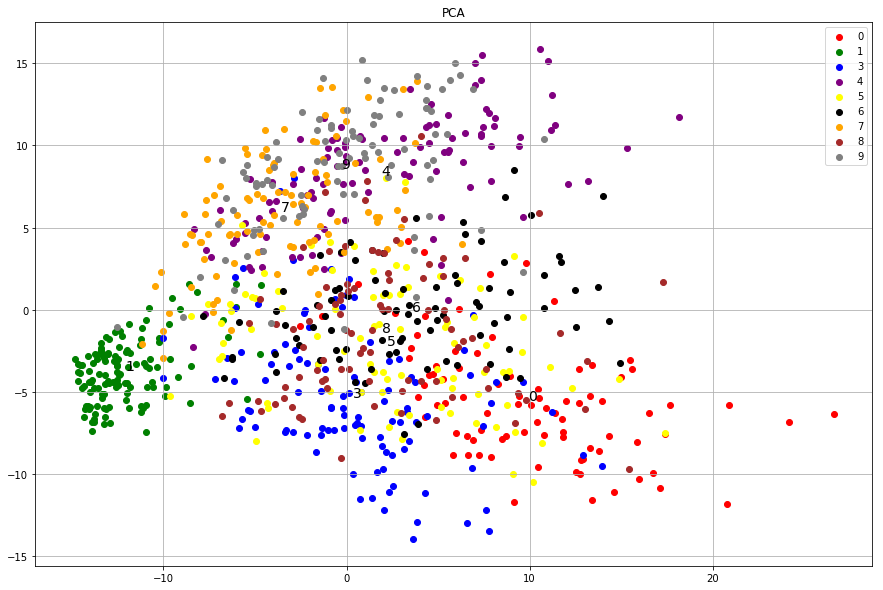

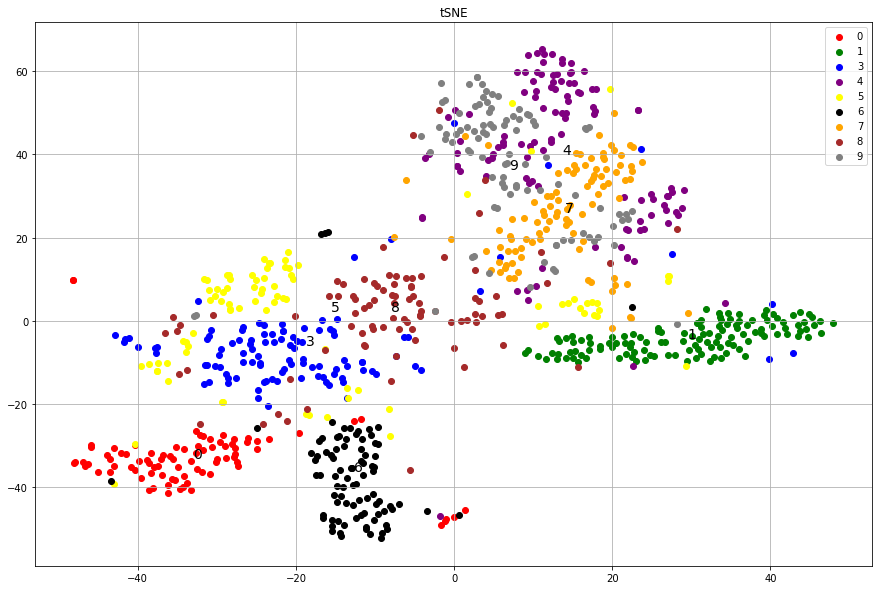

In [24]:
draw_pca_plot(neural_network.data.cpu(), labels)
draw_tsne_plot(neural_network.data.cpu(), labels)


**PCA and tSNE for 1st Hidden Layer**

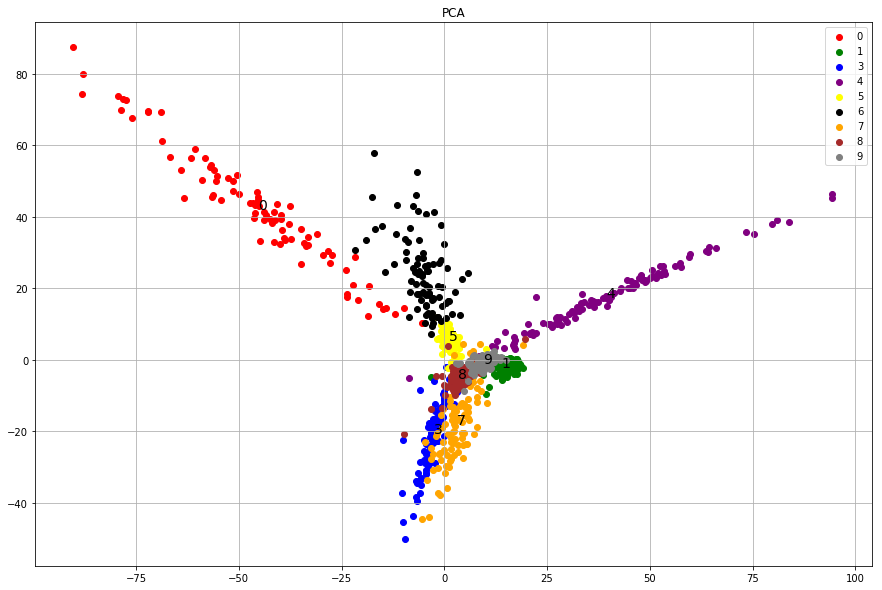

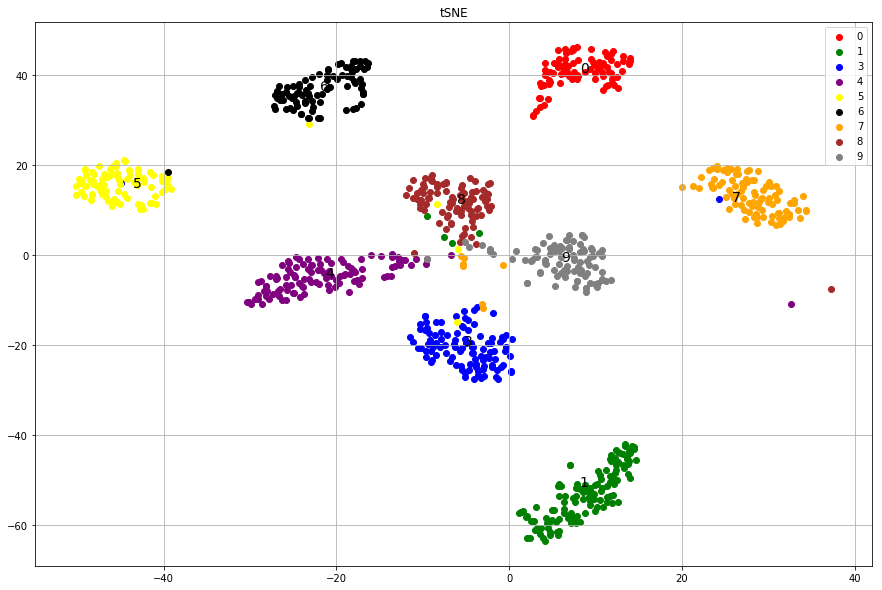

In [25]:
draw_pca_plot(neural_network.output_1st_hidden.cpu(), labels)
draw_tsne_plot(neural_network.output_1st_hidden.cpu(),labels)

**PCA and tSNE for 2nd Hidden Layer**

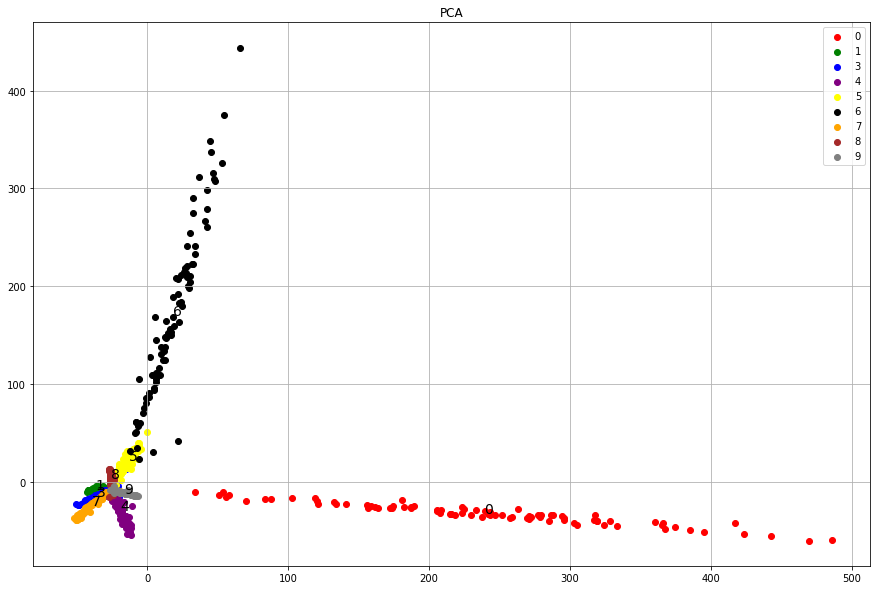

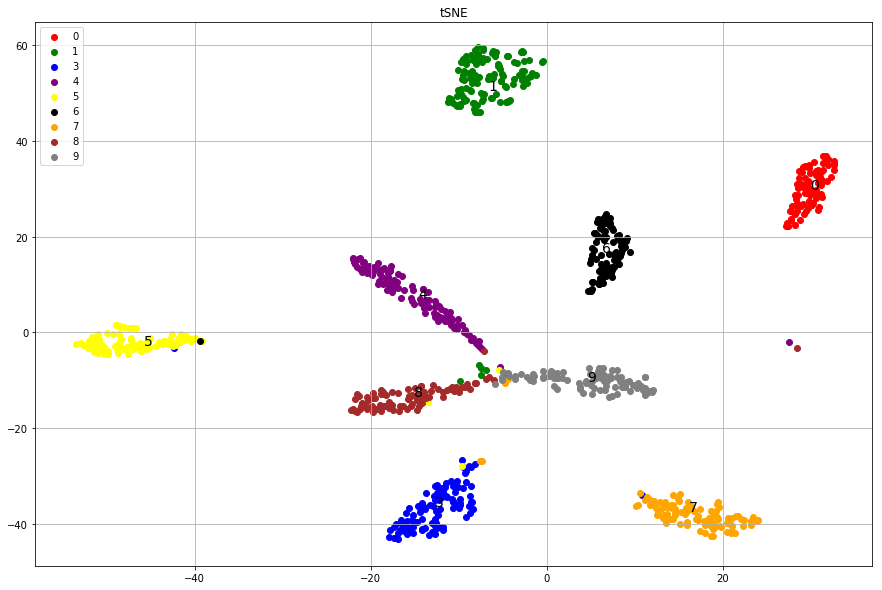

In [26]:
draw_pca_plot(neural_network.output_2nd_hidden.cpu(), labels)
draw_tsne_plot(neural_network.output_2nd_hidden.cpu(), labels)

**PCA and tSNE for 3rd Hidden Layer**

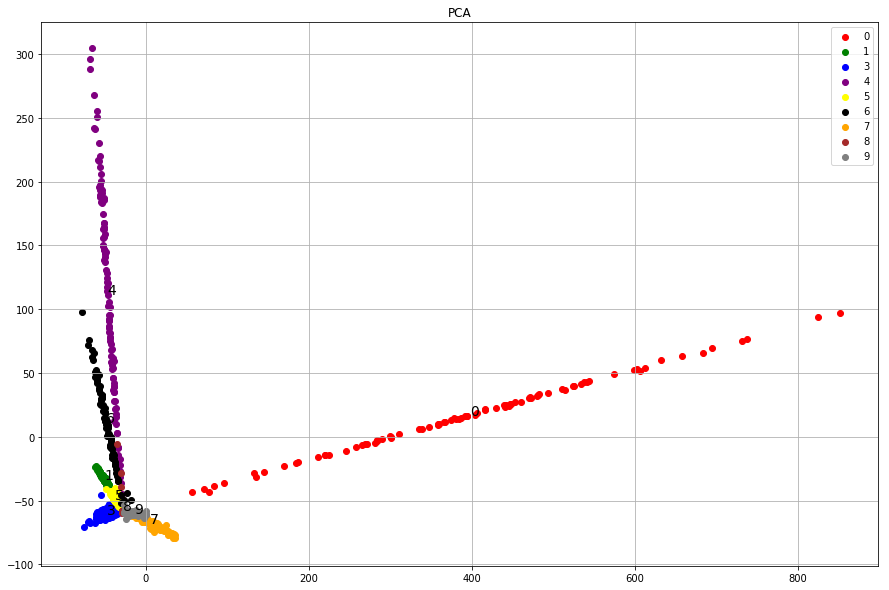

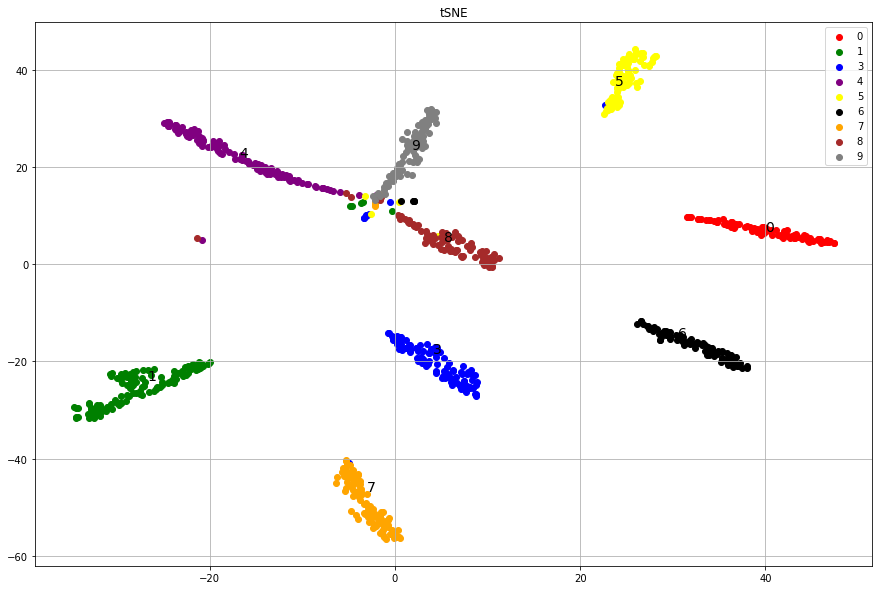

In [27]:
draw_pca_plot(neural_network.output_3rd_hidden.cpu(), labels)
draw_tsne_plot(neural_network.output_3rd_hidden.cpu(), labels)


**PCA and tSNE for 4th Hidden Layer**

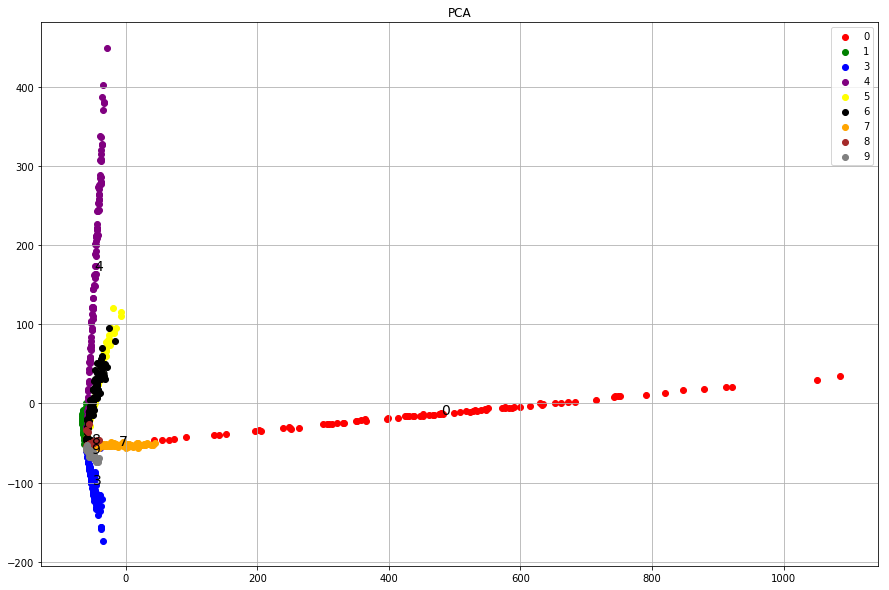

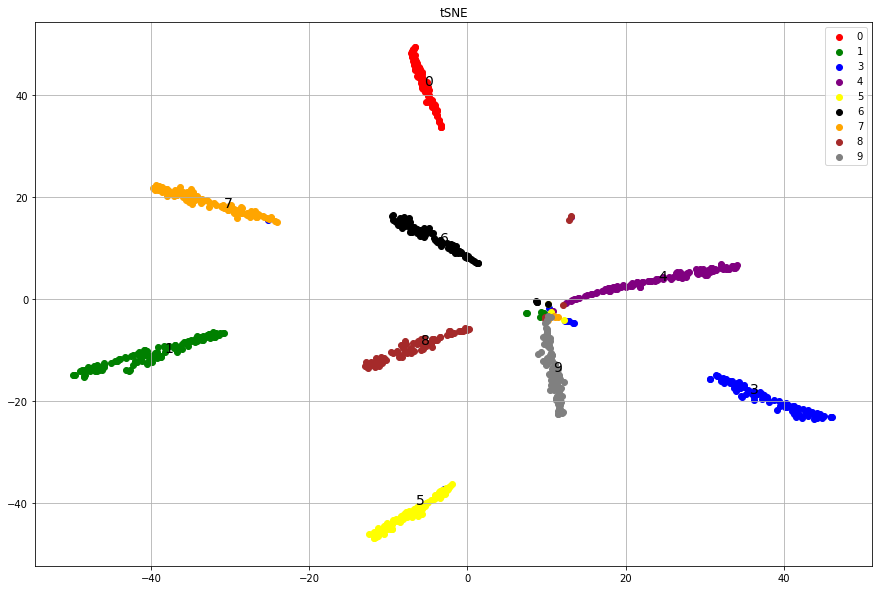

In [28]:
draw_pca_plot(neural_network.output_4th_hidden.cpu(), labels)
draw_tsne_plot(neural_network.output_4th_hidden.cpu(), labels)

**PCA and tSNE for 5th Hidden Layer**

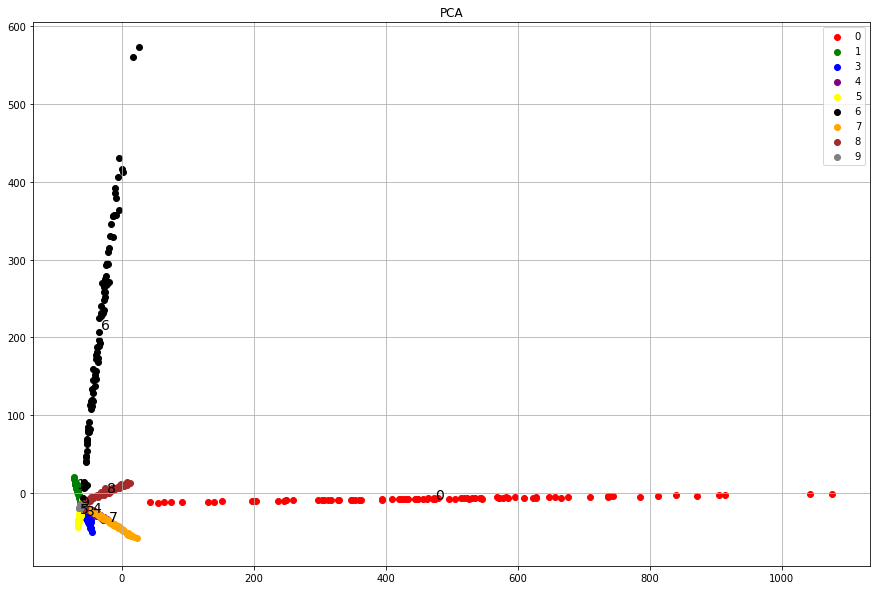

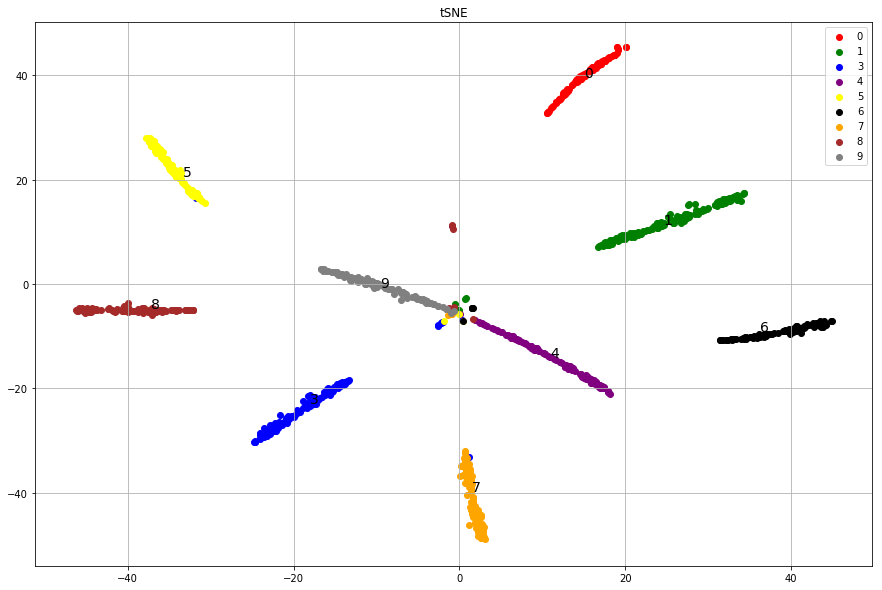

In [29]:
draw_pca_plot(neural_network.output_5th_hidden.cpu(), labels)
draw_tsne_plot(neural_network.output_5th_hidden.cpu(), labels)

**Output from final layer without softmax**

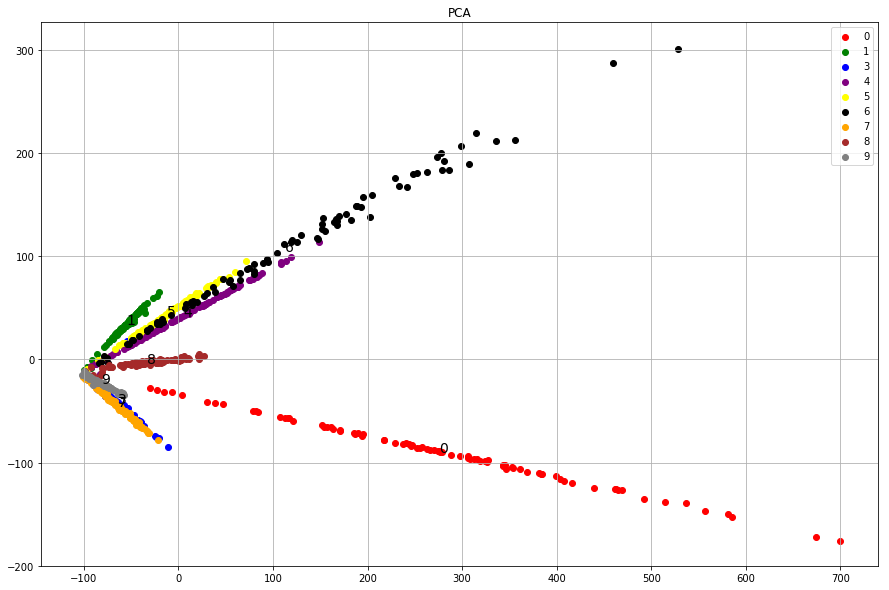

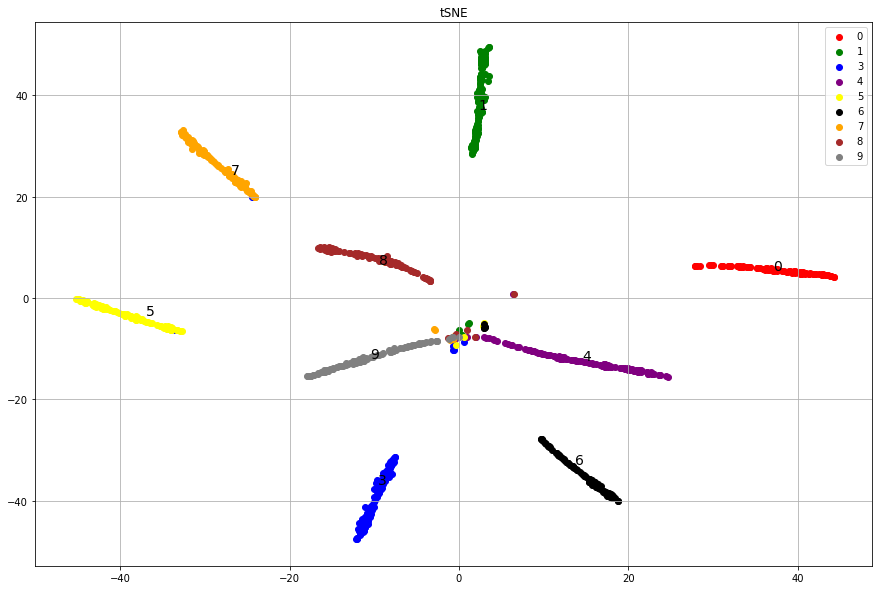

In [30]:
draw_pca_plot(neural_network.final_output.cpu(), labels)
draw_tsne_plot(neural_network.final_output.cpu(), labels)

**PCA and tSNE for Softmax Layer**

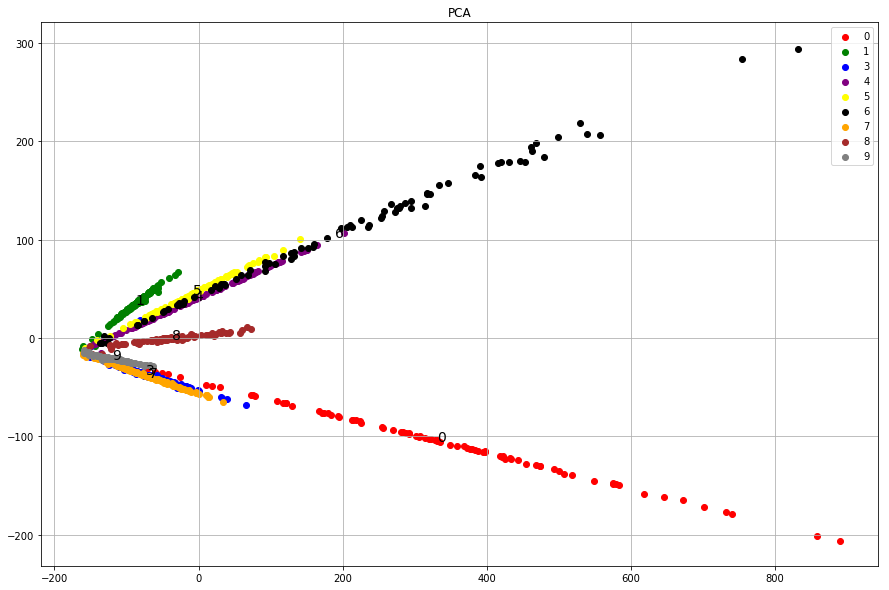

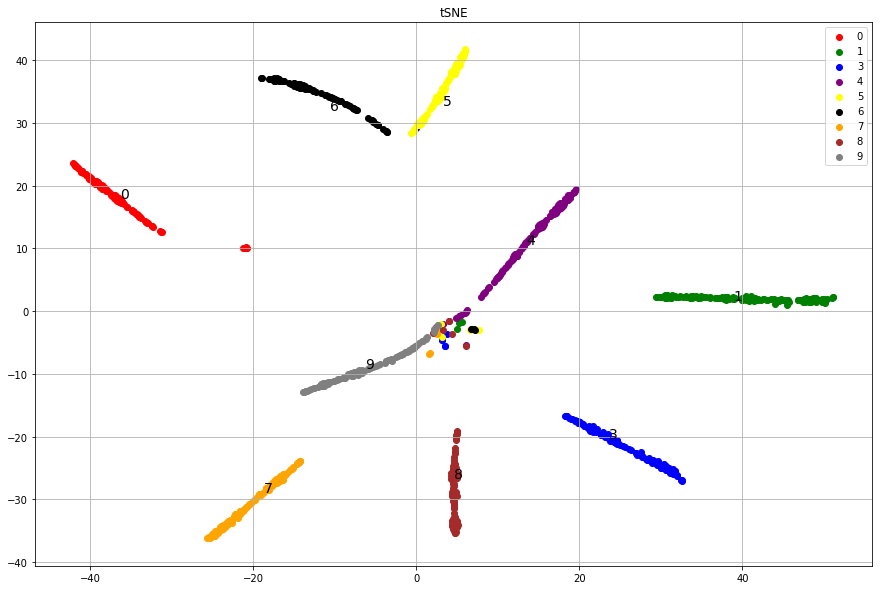

In [31]:
draw_pca_plot(neural_network.softmax_output.cpu(), labels)
draw_tsne_plot(neural_network.softmax_output.cpu(), labels)

**Observations for PCA and tSNE**
1. PCA - I see that x dimensions and y dimensions (difference between min and max) are increasing as we move further in the layers and the labels of same class are getting concentrated in one line and getting closer to each other (closer to mean for y axis). This makes the speration among them easy as compared to what they were in the beginning. All labels are very messy at y =0, I believe at this position the separation would be difficult. As labels move away y = 0 in x direction, the distance between the two consecutive labels of same class increases.
2. tSNE - I see that the axis ranges are not very different from what we started in the beginning but the concentration of lables form same class is high as we move above in the layers. This makes separation easy as compared to lower layers, but we also see that close to y = 0 the separation is not very clear.